In [5]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from d2l import torch as d2l
import numpy as np
import pandas as pd
from ptflops import get_model_complexity_info
from pathlib import Path
import subprocess
import os
import time

### Path

In [6]:
'''find the Model path'''
# find the current path
current_path = os.getcwd()
print('The current path is:', current_path)

# find the parent path
parent_path = Path(current_path).parent
print('The parent path is:', parent_path)

# find the data path
data_path = parent_path / 'Data/alexnet'
print('The data path is:', data_path)

The current path is: /home/yj/FinalThesis/GreenAI/PVWatts/code
The parent path is: /home/yj/FinalThesis/GreenAI/PVWatts
The data path is: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet


### Model

In [3]:
def alexnet(img_channel, num_labels):
    net = nn.Sequential(
        # 这里使用一个11*11的更大窗口来捕捉对象。
        # 同时，步幅为4，以减少输出的高度和宽度。
        # 另外，输出通道的数目远大于LeNet
        nn.Conv2d(img_channel, 64, kernel_size=11, stride=4, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
        nn.Conv2d(64, 192, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # 使用三个连续的卷积层和较小的卷积窗口。
        # 除了最后的卷积层，输出通道的数量进一步增加。
        # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
        nn.Conv2d(192, 384, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.AdaptiveAvgPool2d((6, 6)),   # 使用全局平均池化对每个通道中所有元素求平均并直接将结果传递到全连接层
        nn.Flatten(),
        # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
        nn.Linear(256 * 6 * 6, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(p=0.5),
        # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
        nn.Linear(4096, num_labels))
    return net

In [4]:
# print the model structure
net = alexnet(1, 10)    
# print(net)
# print each layer
layer_name = []
for layer in net:
    name = layer.__class__.__name__
    layer_name.append(name)
# find the unique layer name, and fix the order
layer_name = sorted(list(set(layer_name)))
print('The layer name is:', layer_name)
# the number of layers, which contains ['AdaptiveAvgPool2d', 'Conv2d', 'Dropout', 'Flatten', 'Linear', 'MaxPool2d', 'ReLU']
num_layers = len(layer_name) 
print('The number of layers is:', num_layers)

The layer name is: ['AdaptiveAvgPool2d', 'Conv2d', 'Dropout', 'Flatten', 'Linear', 'MaxPool2d', 'ReLU']
The number of layers is: 7


In [5]:
# 对于不同的数据集，要设置不同的img_channel和num_labels
# Fashion-MNIST中的图像通道数为1，类别数为10
alexnet_f = alexnet(1, 10)

In [6]:
# fashion mnist
with torch.cuda.device(0):
    macs_f, params_f = get_model_complexity_info(alexnet_f, (1, 224, 224), as_strings=True,
                                            print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs_f))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params_f))

Sequential(
  57.03 M, 100.000% Params, 664.65 MMac, 99.868% MACs, 
  (0): Conv2d(7.81 k, 0.014% Params, 23.62 MMac, 3.549% MACs, 1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 193.6 KMac, 0.029% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 193.6 KMac, 0.029% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(307.39 k, 0.539% Params, 224.09 MMac, 33.671% MACs, 64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(0, 0.000% Params, 139.97 KMac, 0.021% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 139.97 KMac, 0.021% MACs, kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(663.94 k, 1.164% Params, 112.21 MMac, 16.859% MACs, 192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(0, 0.000% Params, 64.9 KMac, 0.010% MACs, )
  (8): Conv2d(884.99 k, 1.552% Params, 149.56 MMac, 22.473% MACs, 384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): R

### Datasets

In [7]:
X_f = torch.randn(size=(1, 1, 224, 224), dtype=torch.float32) # fashion mnist

for layer in alexnet_f:
    X_f=layer(X_f)
    print(layer.__class__.__name__,'output shape:\t',X_f.shape)

Conv2d output shape:	 torch.Size([1, 64, 55, 55])
ReLU output shape:	 torch.Size([1, 64, 55, 55])
MaxPool2d output shape:	 torch.Size([1, 64, 27, 27])
Conv2d output shape:	 torch.Size([1, 192, 27, 27])
ReLU output shape:	 torch.Size([1, 192, 27, 27])
MaxPool2d output shape:	 torch.Size([1, 192, 13, 13])
Conv2d output shape:	 torch.Size([1, 384, 13, 13])
ReLU output shape:	 torch.Size([1, 384, 13, 13])
Conv2d output shape:	 torch.Size([1, 256, 13, 13])
ReLU output shape:	 torch.Size([1, 256, 13, 13])
Conv2d output shape:	 torch.Size([1, 256, 13, 13])
ReLU output shape:	 torch.Size([1, 256, 13, 13])
MaxPool2d output shape:	 torch.Size([1, 256, 6, 6])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 256, 6, 6])
Flatten output shape:	 torch.Size([1, 9216])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:

In [8]:
# load the data
# fashion mnist
def get_dataloader_workers():
    """Use 4 processes to read the data.

    Defined in :numref:`sec_utils`"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

### Parameters


In [9]:
batch_size = [128]
epochs = [10]
rounds = 1
### set different power upper limit
# [95,90,85,80,75,70,65,60,55,50,45,40]
power_limit = [40]

### Train Model

In [10]:
def train_func(net, train_iter, test_iter, num_layers, num_epochs, lr, device):
    def init_weights(m): # 初始化权重
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    # create a ndarray to store each layer's total running time of each epoch
    Layers_time = np.zeros((num_layers, num_epochs)) # each row is a layer, each column is an epoch
    Train_part_time = np.zeros((4, num_epochs)) # store the time to device, forward and backward time, and test time of each epoch
    Train_time = np.zeros(num_epochs) # store the total training time of each epoch
    Train_acc = np.zeros(num_epochs) # store the training accuracy of each epoch
    Test_acc = np.zeros(num_epochs) # store the test accuracy of each epoch
    Epoch_time = np.zeros(num_epochs) # store the total time of each epoch
    Epoch_energy = np.zeros((num_epochs,1), dtype='object') # store the total energy of each epoch
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    timer = d2l.Timer()
    train_timer = d2l.Timer()
    ttd_timer = d2l.Timer()
    forward_timer = d2l.Timer()
    backward_timer = d2l.Timer()
    layer_timer = d2l.Timer()
    test_timer = d2l.Timer()
    # start training
    for epoch in range(num_epochs):
        print('The epoch is:', epoch+1)
        timer.start()
        net.train()
        train_epoch, ttd_epoch, forward_epoch, backward_epoch, testtime_epoch= 0.0, 0.0, 0.0, 0.0, 0.0
        layer_epoch = np.zeros((num_layers, 1)) # store the total running time of each layer in one epoch
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples   
        # start the nvidia-smi command
        with open('gpu_power_usage.csv', 'w') as file:
            # Start the nvidia-smi command
            nvidia_smi_process = subprocess.Popen(
                ["nvidia-smi", "--query-gpu=power.draw", "--format=csv", "--loop-ms=1000"],
                stdout=file,  # Redirect the output directly to the file
                stderr=subprocess.PIPE,
                text=True)
        train_timer.start()
        for i, (X, y) in enumerate(train_iter):
            # print('The batch is:', i+1)
            optimizer.zero_grad()
            # to device
            torch.cuda.synchronize()  # 等待数据传输完成
            ttd_timer.start()
            X, y = X.to(device), y.to(device)
            ttd_epoch += ttd_timer.stop()
            # forward
            torch.cuda.synchronize()  # 等待数据传输完成
            forward_timer.start()
            y_hat = X
            for layer in net:
                name = layer.__class__.__name__ # 获取层的名字
                layer_index = layer_name.index(name)
                layer_timer.start()
                y_hat = layer(y_hat)
                torch.cuda.synchronize()  # 等待数据传输完成
                layer_epoch[layer_index] += layer_timer.stop()
            forward_epoch += forward_timer.stop()
            # loss
            l = loss_fn(y_hat, y)
            # backward
            torch.cuda.synchronize()  # 等待数据传输完成
            backward_timer.start()
            l.backward()
            backward_epoch += backward_timer.stop()
            # optimize
            torch.cuda.synchronize()  # 等待数据传输完成
            optimizer.step()
            torch.cuda.synchronize()  # 等待数据传输完成
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_acc = metric[1] / metric[2]
        train_epoch = train_timer.stop()
        test_timer.start()
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        testtime_epoch = test_timer.stop()
        print(f'train acc {train_acc:.3f}, test acc {test_acc:.3f}')
        print('epoch %d, time %f sec' % (epoch+1, timer.sum()))
        # store the time and acc data
        Epoch_time[epoch] = timer.stop()
        print(f'The total time of the {epoch} is:', Epoch_time[epoch])
        Layers_time[:, epoch] = layer_epoch.flatten()
        Train_part_time[:, epoch] = ttd_epoch, forward_epoch, backward_epoch, testtime_epoch
        Train_time[epoch] = train_epoch
        Train_acc[epoch] = train_acc
        Test_acc[epoch] = test_acc
        # stop the nvidia-smi command
        nvidia_smi_process.terminate()
        # calculate the energy consumption of each epoch
        GPU_df = pd.read_csv('gpu_power_usage.csv')
        for row in range(len(GPU_df)):
            GPU_df.iloc[row,0] = GPU_df.iloc[row,0].replace(' W','')
        Consumption_df = GPU_df.astype(float)  
        EnergyDatai = Consumption_df.iloc[:,0].values # 将数据转换为numpy数组
        # store the energy data
        Epoch_energy[epoch,0] = EnergyDatai
    return Layers_time, Train_part_time, Train_time, Train_acc, Test_acc, Epoch_time, Epoch_energy

### Train the model

In [11]:
def train_model_f(main_folder, power, epoch, batchsize, lr, device):
    print(f'The epoch is set to {epoch}, the batch size is set to {batchsize}, the round is set to 1.')
    print(f'The power upper limit of the GPU is set: {power}')
    # create the folder to store the data
    epoch_batch_folder = main_folder/f'Power{power}'
    # 判断文件是否存在
    if epoch_batch_folder.exists():
        print("文件存在。")
        pass
    else:
        os.makedirs(epoch_batch_folder)
        print("文件不存在，已创建。")
        print("文件创建于：", epoch_batch_folder)
        train_iter, test_iter = load_data_fashion_mnist(batchsize, resize=224)
        # show the shape of the data
        list_of_i = []
        for i, (X, y) in enumerate(train_iter):
            if i < 3:
                
                print('the shape of the', i, 'batch of the train_iter is:', X.shape)
            else:
                pass
            list_of_i.append(i)
        print(f'The number of batches is: {np.array(list_of_i).shape}')
        Layers_time, Train_part_time, Train_time, Train_acc, Test_acc, \
            Epoch_time, Epoch_energy = train_func(alexnet_f, train_iter, test_iter, num_layers, epoch, lr, device)
        # save the data
        np.save(epoch_batch_folder/'Layers_time.npy', Layers_time)
        np.save(epoch_batch_folder/'Train_part_time.npy', Train_part_time)
        np.save(epoch_batch_folder/'Train_time.npy', Train_time)
        np.save(epoch_batch_folder/'Train_acc.npy', Train_acc)
        np.save(epoch_batch_folder/'Test_acc.npy', Test_acc)
        np.save(epoch_batch_folder/'Epoch_time.npy', Epoch_time)
        np.save(epoch_batch_folder/'Epoch_energy.npy', Epoch_energy)

In [12]:
lr = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The device is:', device)

The device is: cuda


In [13]:
def set_gpu_power_limit(power_limit):
    """
    设置GPU的功率上限。
    """
    try:
        # 开启持久化模式
        subprocess.run(['sudo', 'nvidia-smi', '-pm', '1'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # 设置功率上限
        subprocess.run(['sudo', 'nvidia-smi', '-pl', str(power_limit)], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        print(f"功率上限设置为 {power_limit}W")
    except subprocess.CalledProcessError as e:
        print(f"设置功率上限时发生错误: {e}")

In [14]:
# create the folder to store the data
main_folder = data_path/'fashion_mnist'
print('The folder is:', main_folder)
epoch = epochs[0]
print('The epoch is:', epoch)
batch_size = batch_size[0]
print('The batch size is:', batch_size)
# find out that if the folder exists in the data path
# 判断文件是否存在
if main_folder.exists():
    print("文件存在。")
else:
    os.makedirs(main_folder)
    print("文件不存在，已创建。")
    print("文件创建于：", main_folder)
for power in power_limit:
    print(f'The power upper limit of the GPU is set to: {power}')
    set_gpu_power_limit(power)
    train_model_f(main_folder, power, epoch, batch_size, lr, device)

The folder is: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist
The epoch is: 10
The batch size is: 128
文件存在。
The power upper limit of the GPU is set to: 40
功率上限设置为 40W
The epoch is set to 10, the batch size is set to 128, the round is set to 1.
The power upper limit of the GPU is set: 40
文件不存在，已创建。
文件创建于： /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power40


the shape of the 0 batch of the train_iter is: torch.Size([128, 1, 224, 224])
the shape of the 1 batch of the train_iter is: torch.Size([128, 1, 224, 224])
the shape of the 2 batch of the train_iter is: torch.Size([128, 1, 224, 224])
The number of batches is: (469,)
training on cuda
The epoch is: 1
train acc 0.540, test acc 0.749
epoch 1, time 0.000000 sec
The total time of the 0 is: 67.33144760131836
The epoch is: 2
train acc 0.769, test acc 0.780
epoch 2, time 67.331448 sec
The total time of the 1 is: 67.8952944278717
The epoch is: 3
train acc 0.811, test acc 0.830
epoch 3, time 135.226742 sec
The total time of the 2 is: 68.26676630973816
The epoch is: 4
train acc 0.835, test acc 0.860
epoch 4, time 203.493508 sec
The total time of the 3 is: 68.8058009147644
The epoch is: 5
train acc 0.852, test acc 0.862
epoch 5, time 272.299309 sec
The total time of the 4 is: 68.64505577087402
The epoch is: 6
train acc 0.862, test acc 0.865
epoch 6, time 340.944365 sec
The total time of the 5 is: 6

### Analysis data

In [7]:
# analysis the data
fashion_path = data_path/'fashion_mnist'
print('The fashion path is:', fashion_path) 

The fashion path is: /home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist


In [8]:
# read all the files
# list all the subfolders under the fashion_path
folders = sorted([f for f in fashion_path.iterdir() if f.is_dir()])
print('The folders are:', folders)
num_folders = len(folders)
print(f'The number of folders is: {num_folders}')

The folders are: [PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power40'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power45'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power50'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power55'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power60'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power65'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power70'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power75'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power80'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power85'), PosixPath('/home/yj/FinalThesis/GreenAI/PVWatts/Data/alexnet/fashion_mnist/Power90'), PosixPath('/home/yj/FinalThesis/Gree

In [9]:
# create a ndarray to store the Epoch_time, Train_time, Train_acc, Test_acc, Layers_time, Train_part_time, Epoch_energy
PowerLimit = np.zeros((num_folders, 1))
Energy = np.zeros((num_folders, 1))
Acc = np.zeros((num_folders, 1))   
avgEnergy = np.zeros((num_folders, 1))
Power = np.zeros((num_folders, 1))
Total_time = np.zeros((num_folders, 1))
avg_time = np.zeros((num_folders, 1))



for folder in folders:
    PowerLimit_num = folder.name.split('Power')[1]
    # print(f'The PowerLimit is: {PowerLimit_num}')
    # find the folder index
    folder_index = folders.index(folder)
    # print('The folder index is:', folder_index)
    PowerLimit[folder_index, 0] = PowerLimit_num
    # read the files that stored in the folder
    files = sorted(list(folder.iterdir()))
    # print('The files in the folder are:', files)
    power_epoch = []
    totalenergy_epoch = []
    for file in files:
        if 'Epoch_energy.npy' in str(file):
            energy_data = np.load(file, allow_pickle=True)
            for epoch in range(len(energy_data)):
                energy_perepoch = energy_data[epoch][0]
                # print(f'The energy data of the {epoch} epoch is:', energy_perepoch)
                totalenergy_epoch.append(np.sum(energy_perepoch))
                power_epoch.append(np.mean(energy_perepoch))
        elif 'Test_acc.npy' in str(file):
            acc = np.load(file)
            # print('The accuracy data is:', acc)
        elif 'Epoch_time.npy' in str(file):
            epoch_time = np.load(file)
            # print('The epoch time is:', epoch_time)
        else:
            pass
    power = np.mean(power_epoch)
    Power[folder_index, 0] = np.mean(power)
    avgenergy = np.mean(totalenergy_epoch)
    avgEnergy[folder_index, 0] = avgenergy
    totalenergy = np.sum(totalenergy_epoch)
    Energy[folder_index, 0] = totalenergy
    Acc[folder_index, 0] = acc[-1]
    Total_time[folder_index, 0] = np.sum(epoch_time)
    avg_time[folder_index, 0] = np.mean(epoch_time)
print(f'The PowerLimit is: {PowerLimit}')
print(f'The Energy is: {Energy}')
print(f'The Acc is: {Acc}')
print(f'The avgEnergy is: {avgEnergy}')
print(f'The Power is: {Power}')
print(f'The Total_time is: {Total_time}')
print(f'The avg_time is: {avg_time}')

The PowerLimit is: [[40.]
 [45.]
 [50.]
 [55.]
 [60.]
 [65.]
 [70.]
 [75.]
 [80.]
 [85.]
 [90.]
 [95.]]
The Energy is: [[27294.61]
 [23948.04]
 [23742.31]
 [24454.3 ]
 [25517.19]
 [26319.2 ]
 [27481.46]
 [28757.  ]
 [29734.89]
 [31404.39]
 [32295.39]
 [33758.72]]
The Acc is: [[0.8703]
 [0.89  ]
 [0.8891]
 [0.8848]
 [0.8874]
 [0.8889]
 [0.8905]
 [0.8732]
 [0.8888]
 [0.8889]
 [0.8855]
 [0.8891]]
The avgEnergy is: [[2729.461]
 [2394.804]
 [2374.231]
 [2445.43 ]
 [2551.719]
 [2631.92 ]
 [2748.146]
 [2875.7  ]
 [2973.489]
 [3140.439]
 [3229.539]
 [3375.872]]
The Power is: [[39.67214024]
 [44.34822222]
 [49.46313188]
 [54.34288889]
 [59.34230233]
 [64.19317073]
 [68.87619936]
 [73.73589744]
 [78.24971053]
 [82.64313158]
 [87.28483784]
 [91.48621547]]
The Total_time is: [[684.55057716]
 [536.43928146]
 [474.08920503]
 [445.2466526 ]
 [428.78904581]
 [408.60098577]
 [393.66673326]
 [384.88446808]
 [378.47114778]
 [372.19375229]
 [366.73953819]
 [362.71329618]]
The avg_time is: [[68.45505772]
 

### plot the figure

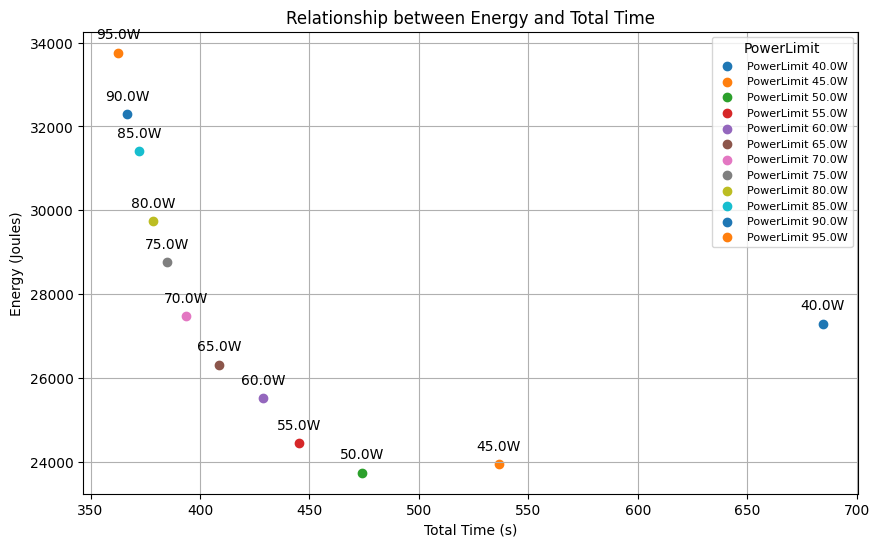

In [10]:
import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(10, 6))
for i in range(len(PowerLimit)):
    plt.scatter(Total_time[i], Energy[i], label=f'PowerLimit {PowerLimit[i][0]}W')

# Adding annotations for each point
for i, txt in enumerate(PowerLimit):
    plt.annotate(f'{txt[0]}W', (Total_time[i], Energy[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Relationship between Energy and Total Time')
plt.xlabel('Total Time (s)')
plt.ylabel('Energy (Joules)')
plt.legend(title="PowerLimit",fontsize=8)
plt.grid(True)
plt.show()



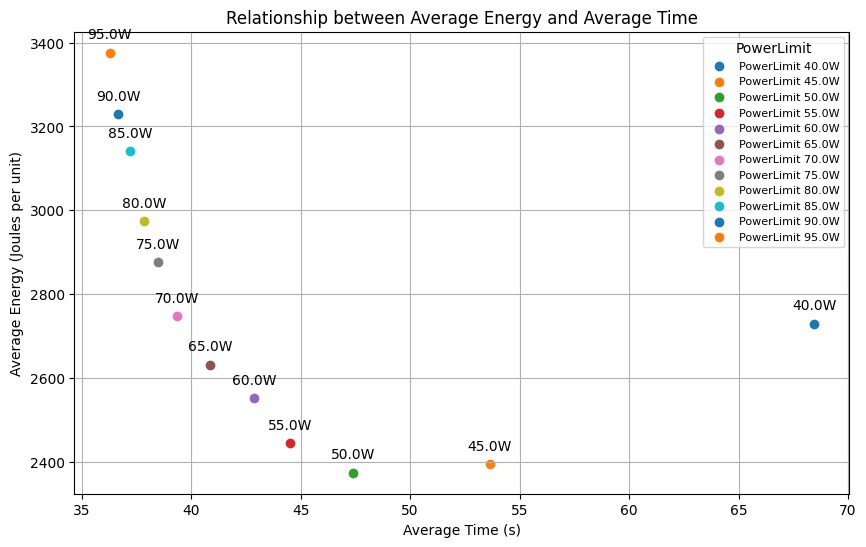

In [11]:
# Defining the avg_time array
avg_time = np.array([[68.45505772], [53.64392815], [47.4089205 ], [44.52466526], [42.87890458], [40.86009858],
                     [39.36667333], [38.48844681], [37.84711478], [37.21937523], [36.67395382], [36.27132962]])

# Creating the plot for avgEnergy vs. avg_time
plt.figure(figsize=(10, 6))
for i in range(len(PowerLimit)):
    plt.scatter(avg_time[i], avgEnergy[i], label=f'PowerLimit {PowerLimit[i][0]}W')

# Adding annotations for each point
for i, txt in enumerate(PowerLimit):
    plt.annotate(f'{txt[0]}W', (avg_time[i], avgEnergy[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Relationship between Average Energy and Average Time')
plt.xlabel('Average Time (s)')
plt.ylabel('Average Energy (Joules per unit)')
plt.legend(title="PowerLimit",fontsize=8)
plt.grid(True)
plt.show()


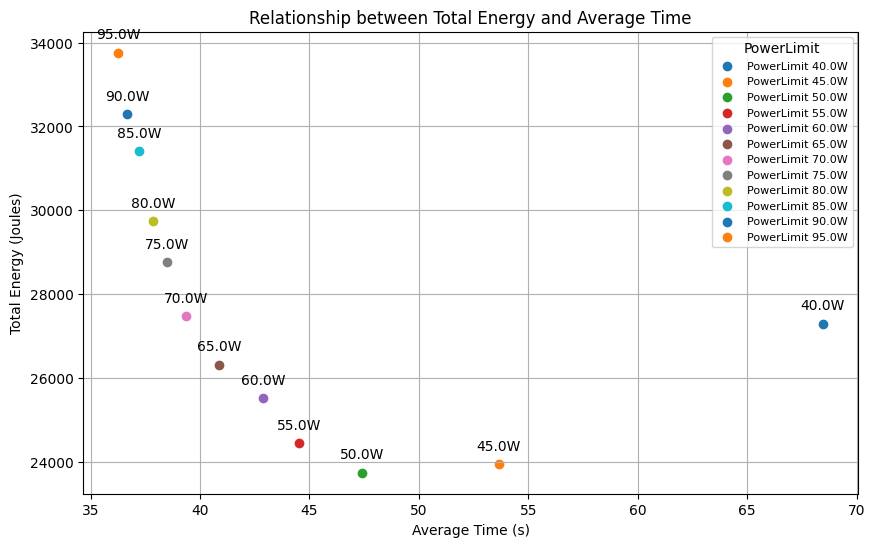

In [12]:
# Creating the plot for Energy vs. avg_time
plt.figure(figsize=(10, 6))
for i in range(len(PowerLimit)):
    plt.scatter(avg_time[i], Energy[i], label=f'PowerLimit {PowerLimit[i][0]}W')

# Adding annotations for each point
for i, txt in enumerate(PowerLimit):
    plt.annotate(f'{txt[0]}W', (avg_time[i], Energy[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Relationship between Total Energy and Average Time')
plt.xlabel('Average Time (s)')
plt.ylabel('Total Energy (Joules)')
plt.legend(title="PowerLimit",fontsize=8)
plt.grid(True)
plt.show()


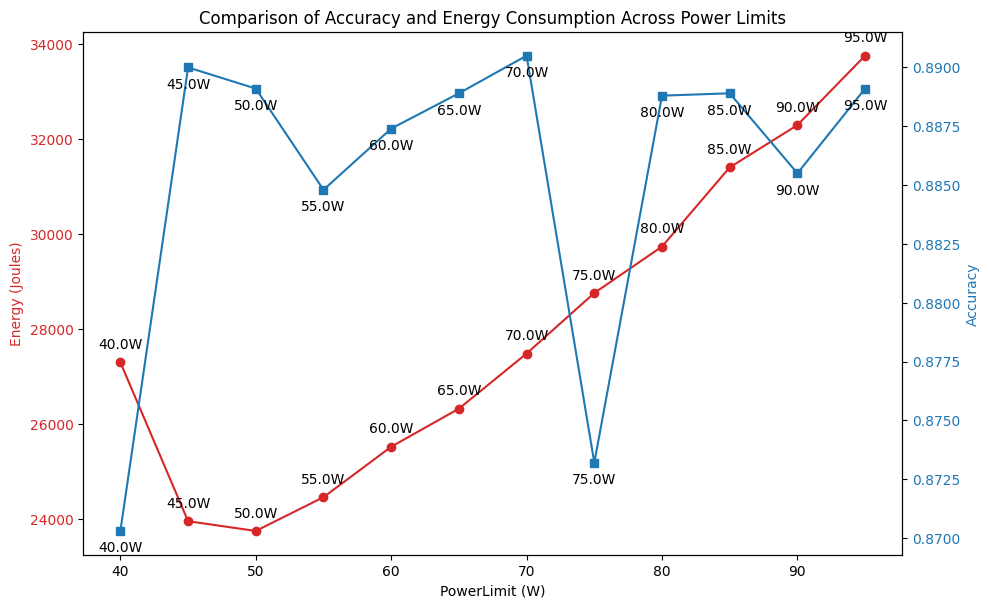

In [13]:
# Creating the plot for Acc and Energy on the same figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('PowerLimit (W)')
ax1.set_ylabel('Energy (Joules)', color=color)
ax1.plot(PowerLimit, Energy, 'o-', color=color, label='Energy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(PowerLimit, Acc, 's-', color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Adding annotations for PowerLimit on Energy points
for i, txt in enumerate(PowerLimit):
    ax1.annotate(f'{txt[0]}W', (PowerLimit[i], Energy[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Adding annotations for PowerLimit on Acc points
for i, txt in enumerate(PowerLimit):
    ax2.annotate(f'{txt[0]}W', (PowerLimit[i], Acc[i]), textcoords="offset points", xytext=(0,-15), ha='center')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparison of Accuracy and Energy Consumption Across Power Limits')
plt.show()
